In [7]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# Đọc dữ liệu từ file CSV và in ra để kiểm tra
df = pd.read_csv('BITCOIN24.csv')
# Chuyển đổi cột Date thành datetime và sắp xếp theo ngày tăng dần
try:
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
    df = df.sort_values('Date').reset_index(drop=True)
    print("Date parsed and sorted.")
except Exception as e:
    print("Lỗi parse date:", str(e))
    

Date parsed and sorted.


In [126]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Sau khi df đã được đọc và sắp xếp theo Date tăng dần
features = ['Open', 'High', 'Low', 'Close']
data = df[features].copy()

# ===== CHUẨN HÓA DỮ LIỆU =====
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = pd.DataFrame(
    scaler.fit_transform(data),
    columns=features,
    index=data.index
)


lag = 10  # Số ngày quá khứ dùng để dự đoán

X = []
y = []

for i in range(len(data_scaled) - lag):
    # Lấy lag ngày liên tiếp làm input (từ i đến i+lag-1)
    X.append(data_scaled.iloc[i:i + lag].values)      
    # Dự đoán giá Close của ngày tiếp theo (i + lag)
    y.append(data_scaled.iloc[i + lag]['Close'])

X = np.array(X)   
y = np.array(y)   

print("X shape:", X.shape)  
print("y shape:", y.shape)  

X shape: (2240, 10, 4)
y shape: (2240,)


In [ ]:
# ===== CHIA TRAIN/TEST =====
train_size = int(len(X) * 0.8)
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

# ===== FLATTEN CHO MLP  =====
# MLP chỉ nhận vector phẳng → reshape thành (samples, lag * 4)
X_train_mlp = X_train.reshape(X_train.shape[0], -1)  # ví dụ lag=5 → (1791, 20)
X_test_mlp = X_test.reshape(X_test.shape[0], -1)      # ví dụ lag=5 → (448, 20)

# Chuyển thành tensor
X_train_tensor = torch.FloatTensor(X_train_mlp)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)

X_test_tensor = torch.FloatTensor(X_test_mlp)  # ← Giờ đúng shape (448, 20)

# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

------------------- MLP Model ------------------------

In [128]:
import torch.nn as nn

class MLP_Level1(nn.Module):
    def __init__(self, input_size=40, hidden_size=32):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc_out = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # x: (batch, 4)
        x = self.relu(self.fc1(x))
        x = self.fc_out(x)
        return x.squeeze(-1)  # return shape (batch,)

In [ ]:
class MLP_Level2(nn.Module):
    def __init__(self, input_size=40, hidden1=64, hidden2=32, dropout=0.2):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden1)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.dropout2 = nn.Dropout(dropout)
        self.fc_out = nn.Linear(hidden2, 1)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc_out(x)
        return x.squeeze(-1)

In [130]:
class MLP_Level3(nn.Module):
    def __init__(self, input_size=40, h1=128, h2=64, h3=32, dropout=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_size, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.fc_out = nn.Linear(h3, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc_out(x)
        return x.squeeze(-1)

In [131]:
# Train function (giữ nguyên)
def train_model(model, loader, epochs=100, lr=0.001, patience=10):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    best_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(loader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss}")
        if avg_loss < best_loss:
            best_loss = avg_loss
            
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping at epoch", epoch+1)
            break
    return model

In [132]:
mlp1 = MLP_Level1()
mlp2 = MLP_Level2()
mlp3 = MLP_Level3()

In [135]:
# Train MLP
#mlp_model = MLP()
mlp_model = train_model(mlp3, train_loader)

# Predict MLP
mlp_model.eval()
with torch.no_grad():
    y_pred_mlp = mlp_model(X_test_tensor).numpy().flatten()

# Metrics MLP
rmse_mlp = sqrt(mean_squared_error(y_test, y_pred_mlp))
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
mape_mlp = np.mean(np.abs((y_test - y_pred_mlp) / y_test)) * 100
r2_mlp = r2_score(y_test, y_pred_mlp)

print("MLP Metrics:")
print(f"RMSE: {rmse_mlp}")
print(f"MAE: {mae_mlp}")
print(f"MAPE: {mape_mlp}")
print(f"R2: {r2_mlp}")

/Users/mong/Documents/ComputerScience/venv/lib/python3.14/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 0.02785285417901053
Epoch 2, Loss: 0.03869643820975658
Epoch 3, Loss: 0.02302201903824295
Epoch 4, Loss: 0.018873174947137677
Epoch 5, Loss: 0.018312335180650865
Epoch 6, Loss: 0.022443601123606122
Epoch 7, Loss: 0.02378836917445629
Epoch 8, Loss: 0.020714504313738353
Epoch 9, Loss: 0.021574556513639567
Epoch 10, Loss: 0.01772957238946609
Epoch 11, Loss: 0.017589463555071103
Epoch 12, Loss: 0.017076674699637806
Epoch 13, Loss: 0.016649658092189514
Epoch 14, Loss: 0.01695497646038088
Epoch 15, Loss: 0.014324652939519313
Epoch 16, Loss: 0.017232833120942814
Epoch 17, Loss: 0.014853398020412507
Epoch 18, Loss: 0.02006173469843426
Epoch 19, Loss: 0.025155646437009897
Epoch 20, Loss: 0.01696550661186588
Epoch 21, Loss: 0.016339731087230445
Epoch 22, Loss: 0.016818930489534978
Epoch 23, Loss: 0.013640088805134707
Epoch 24, Loss: 0.015079571546916018
Epoch 25, Loss: 0.01423554101971344
Epoch 26, Loss: 0.017262835480193774
Epoch 27, Loss: 0.010719435610683701
Epoch 28, Loss: 0.0

----------------------- SimpleRNN model --------------------------

In [157]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# Giả sử X (shape: samples, lag, 4) và y (shape: samples,) đã có sẵn từ trước

total_samples = len(X)
train_ratio = 0.8
train_size = int(total_samples * train_ratio)  # Làm tròn xuống

# Chia dữ liệu theo thời gian (train trước, test sau – đúng cho time series)
X_train = X[:train_size]
X_test  = X[train_size:]
y_train = y[:train_size]
y_test  = y[train_size:]

# Kiểm tra độ dài để đảm bảo không lệch
print(f"Total samples: {total_samples}")
print(f"Train samples: {len(X_train)} (X), {len(y_train)} (y)")
print(f"Test samples : {len(X_test)} (X), {len(y_test)} (y)")


X_train_tensor = torch.FloatTensor(X_train)   
X_test_tensor  = torch.FloatTensor(X_test)    

y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)  
y_test_tensor  = torch.FloatTensor(y_test).unsqueeze(1)    


# Nếu vô tình có chiều thừa (4D)
if X_train_tensor.dim() == 4:
    X_train_tensor = X_train_tensor.squeeze(-1)
    X_test_tensor  = X_test_tensor.squeeze(-1)

# DataLoader dành riêng cho RNN
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=False  
)

print("\n=== Shape  ===")
print(f"X_train_tensor: {X_train_tensor.shape}")   
print(f"X_test_tensor : {X_test_tensor.shape}")    
print(f"y_train_tensor: {y_train_tensor.shape}")   
print(f"y_test_tensor : {y_test_tensor.shape}")    

Total samples: 2240
Train samples: 1792 (X), 1792 (y)
Test samples : 448 (X), 448 (y)

=== Shape  ===
X_train_tensor: torch.Size([1792, 10, 4])
X_test_tensor : torch.Size([448, 10, 4])
y_train_tensor: torch.Size([1792, 1])
y_test_tensor : torch.Size([448, 1])


In [158]:
class RNN_Level1(nn.Module):
    def __init__(self, input_size=4, hidden_size=64, dropout=0.2):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1,
                          batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(32, 1)
    
    def forward(self, x):
        # x: (batch, seq_len=1, 4)
        _, hn = self.rnn(x)          # hn: (1, batch, hidden)
        x = hn.squeeze(0)            # (batch, hidden)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc_out(x)
        return x.squeeze(-1)

In [143]:
class RNN_Level2(nn.Module):
    def __init__(self, input_size=4, hidden_size=96, dropout=0.3):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=2,
                          batch_first=True, dropout=dropout)  # Dropout giữa 2 lớp
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(32, 1)
    
    def forward(self, x):
        _, hn = self.rnn(x)          # hn: (2, batch, hidden)
        x = hn[-1]                   # Lấy hidden của lớp thứ 2
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc_out(x)
        return x.squeeze(-1)

In [144]:
class RNN_Level3(nn.Module):
    def __init__(self, input_size=4, hidden_size=128, dropout=0.4):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=3,
                          batch_first=True, dropout=dropout)  # Dropout giữa các lớp
        self.fc1 = nn.Linear(hidden_size, 96)
        self.fc2 = nn.Linear(96, 64)
        self.fc3 = nn.Linear(64, 32)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(32, 1)
    
    def forward(self, x):
        _, hn = self.rnn(x)          # hn: (3, batch, hidden)
        x = hn[-1]                   # Lấy hidden của lớp thứ 3
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc_out(x)
        return x.squeeze(-1)

In [149]:
rnn1 = RNN_Level1()
rnn2 = RNN_Level2()
rnn3 = RNN_Level3()

In [161]:
# Train RNN
#rnn_model = SimpleRNN()
rnn_model = train_model(rnn1, train_loader)

# Predict RNN
rnn_model.eval()
with torch.no_grad():
    y_pred_rnn = rnn_model(X_test_tensor).cpu().numpy().flatten()  # ← Đảm bảo tên biến đúng

# Kiểm tra độ dài - DÙNG ĐÚNG BIẾN y_pred_rnn
print("len(y_test):", len(y_test))
print("len(y_pred_rnn):", len(y_pred_rnn))  # ← Sửa từ y_pred_mlp thành y_pred_rnn

assert len(y_test) == len(y_pred_rnn), "Số mẫu không khớp!"

# Metrics RNN - giờ sẽ chạy ngon
rmse_rnn = sqrt(mean_squared_error(y_test, y_pred_rnn))
mae_rnn = mean_absolute_error(y_test, y_pred_rnn)
mape_rnn = np.mean(np.abs((y_test - y_pred_rnn) / y_test)) 
r2_rnn = r2_score(y_test, y_pred_rnn)

print("\nSimpleRNN Metrics:")
print(f"RMSE: {rmse_rnn:.4f}")
print(f"MAE: {mae_rnn:.4f}")
print(f"MAPE: {mape_rnn:.2f}")
print(f"R²: {r2_rnn:.4f}")


/Users/mong/Documents/ComputerScience/venv/lib/python3.14/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 0.0060848972963348
Epoch 2, Loss: 0.008515926562332814
Epoch 3, Loss: 0.012479846274800366
Epoch 4, Loss: 0.014206859176088724
Epoch 5, Loss: 0.010149503101794315
Epoch 6, Loss: 0.006733023598436765
Epoch 7, Loss: 0.005328376166289672
Epoch 8, Loss: 0.0057331552876088866
Epoch 9, Loss: 0.008155040580667057
Epoch 10, Loss: 0.008093798738887667
Epoch 11, Loss: 0.006823855273458841
Epoch 12, Loss: 0.006149248705436808
Epoch 13, Loss: 0.00567767571711946
Epoch 14, Loss: 0.005797985320636404
Epoch 15, Loss: 0.006068710450823086
Epoch 16, Loss: 0.005831496300483455
Epoch 17, Loss: 0.005627533040491731
Early stopping at epoch 17
len(y_test): 448
len(y_pred_rnn): 448

SimpleRNN Metrics:
RMSE: 0.0230
MAE: 0.0185
MAPE: 0.05
R²: 0.9706


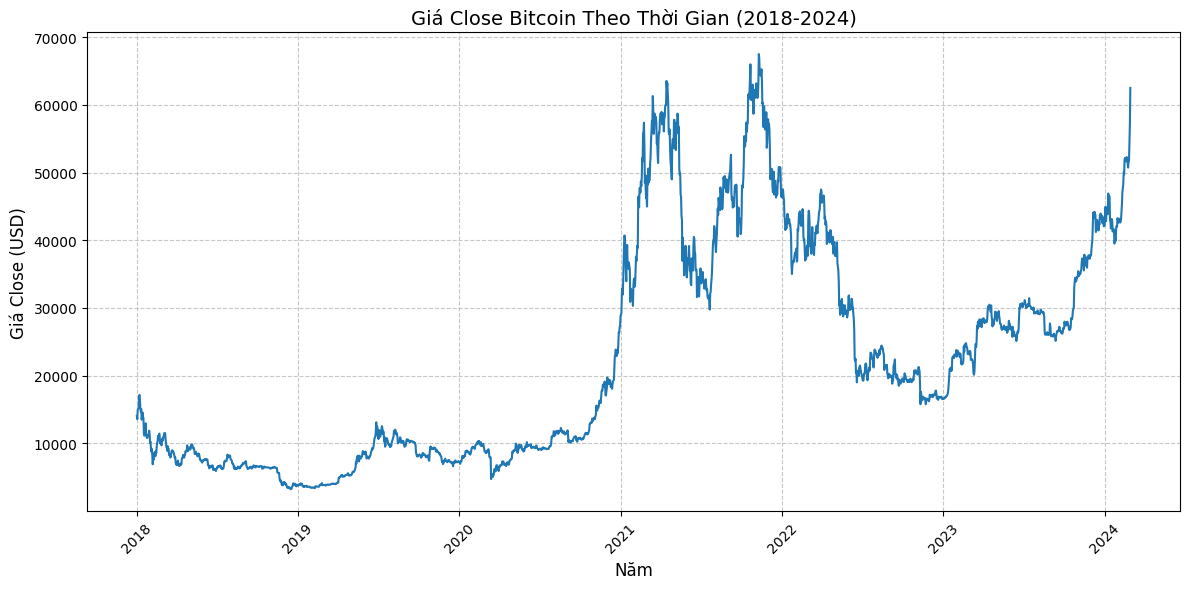

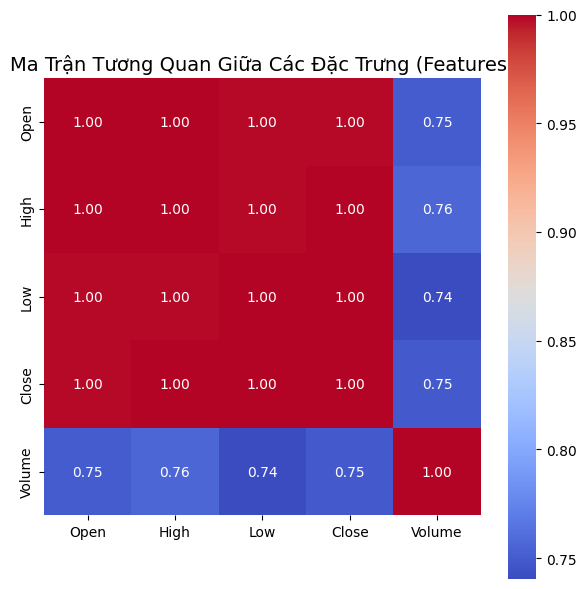

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Đọc và làm sạch dữ liệu
data = pd.read_csv('BITCOIN24.csv', parse_dates=['Date'], dayfirst=True)
data = data.sort_values('Date').reset_index(drop=True)

# Chuyển đổi các cột sang kiểu số
cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']
for col in cols:
    data[col] = pd.to_numeric(data[col].astype(str).str.replace(',', ''), errors='coerce')

# 2. Biểu đồ 1: Diễn biến giá Close Bitcoin
# Sử dụng plt.subplots() theo hướng dẫn để quản lý các trục tốt hơn
fig1, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(data['Date'], data['Close'], color='tab:blue', linewidth=1.5)

ax1.set_title('Giá Close Bitcoin Theo Thời Gian (2018-2024)', fontsize=14)
ax1.set_xlabel('Năm', fontsize=12)
ax1.set_ylabel('Giá Close (USD)', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)

# Xoay nhãn ngày tháng để không bị chồng chéo
plt.xticks(rotation=45)
plt.tight_layout()
fig1.savefig('bitcoin_close_price.png')

# 3. Biểu đồ 2: Ma trận tương quan
features = ['Open', 'High', 'Low', 'Close', 'Volume']
corr = data[features].corr()

fig2, ax2 = plt.subplots(figsize=(6, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', ax=ax2, square=True)

ax2.set_title('Ma Trận Tương Quan Giữa Các Đặc Trưng (Features)', fontsize=14)
plt.tight_layout()
fig2.savefig('correlation_heatmap.png')